In [1]:
import pandas as pd
import numpy as np
import re
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score


2025-04-15 04:14:44.171737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744690484.404452      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744690484.466506      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip -d glove
# # !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz
# # !gunzip cc.hi.300.vec.gz
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # print(f"Using device: {device}")

--2025-04-15 04:16:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-15 04:16:45--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-15 04:16:45--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip -q /kaggle/input/glove6b/glove.6B.zip -d /kaggle/working/

In [3]:
# Load each CSV
df_l1 = pd.read_csv("/kaggle/input/english/train_en_l1.csv")
df_l3 = pd.read_csv("/kaggle/input/english/train_en_l3.csv")

# Majority voting for each label
annotation_cols_1 = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5','en_a6']
annotation_cols_3 = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5','en_a6']

def get_majority_label(row):
    valid_votes = [float(v) for v in row if str(v).replace('.', '', 1).isdigit() and float(v) in [0.0, 1.0]]
    if not valid_votes:
        return None
    return 1 if valid_votes.count(1.0) >= valid_votes.count(0.0) else 0

# Add labels
df_l1['label_1'] = df_l1[annotation_cols_1].apply(get_majority_label, axis=1)
df_l3['label_3'] = df_l3[annotation_cols_3].apply(get_majority_label, axis=1)

# Normalize text for both
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"<handle replaced>", "[USER]", text)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(rf"[{string.punctuation}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_l1['text'] = df_l1['text'].apply(normalize_text)
df_l3['text'] = df_l3['text'].apply(normalize_text)


# Merge by normalized text
df = pd.merge(df_l1[['text', 'label_1']], df_l3[['text', 'label_3']], on='text', how='inner')

# Drop missing labels and ensure integer type
df = df.dropna()
df[['label_1', 'label_3']] = df[['label_1', 'label_3']].astype(int)



# Load HurtLex lexicon
hurtlex_df = pd.read_csv('/kaggle/input/english/hurtlex_EN.tsv', sep='\t', engine='python', on_bad_lines='skip')
hurtlex_dict = {}
for _, row in hurtlex_df.iterrows():
    word = str(row['lemma']).strip().lower()
    cat = str(row['category']).strip()
    if word not in hurtlex_dict:
        hurtlex_dict[word] = set()
    hurtlex_dict[word].add(cat)

# Create category index
all_categories = sorted({c for cats in hurtlex_dict.values() for c in cats})
cat2idx = {c: i for i, c in enumerate(all_categories)}
num_cats = len(cat2idx)

# HurtLex vectorizer
def get_hurtlex_vector(text):
    vec = np.zeros(num_cats)
    for token in text.split():
        if token in hurtlex_dict:
            for cat in hurtlex_dict[token]:
                vec[cat2idx[cat]] = 1
    return vec

# Generate features
hurtlex_features = np.array([get_hurtlex_vector(text) for text in df['text']])





# GloVe-based tokenizer
max_features = 4479
max_len = 100
embed_size = 300

keras_tokenizer = Tokenizer(num_words=max_features)
keras_tokenizer.fit_on_texts(df['text'])
X_seq = keras_tokenizer.texts_to_sequences(df['text'])
X_glove = pad_sequences(X_seq, maxlen=max_len, padding='post')

# Labels
label_encoder = LabelEncoder()
# Correct multilabel target matrix (shape: [N, 2])
y = df[['label_1', 'label_3']].values


# Load GloVe embeddings
embeddings_index = {}
with open('/kaggle/working/glove/glove.6B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word, coefs = values[0], np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((max_features, embed_size))
for word, i in keras_tokenizer.word_index.items():
    if i < max_features and word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]

In [4]:
# class FusionDataset(Dataset):
#     def __init__(self, texts, glove_inputs, labels, tokenizer, max_len=128):
#         self.texts = texts
#         self.glove_inputs = glove_inputs
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         bert_encoded = self.tokenizer.encode_plus(
#             self.texts[idx],
#             add_special_tokens=True,
#             max_length=self.max_len,
#             padding='max_length',
#             truncation=True,
#             return_tensors='pt'
#         )
#         return {
#             'input_ids': bert_encoded['input_ids'].squeeze(),
#             'attention_mask': bert_encoded['attention_mask'].squeeze(),
#             'glove_input': torch.tensor(self.glove_inputs[idx], dtype=torch.long),
#             'label': torch.tensor(self.labels[idx], dtype=torch.long)
#         }


# class FusionDataset(Dataset):
#     def __init__(self, texts, glove_inputs, labels, tokenizer, hurtlex_inputs=None, max_len=128):
#         self.texts = texts
#         self.glove_inputs = glove_inputs
#         self.labels = labels  # shape: (N, 2)
#         self.tokenizer = tokenizer
#         self.hurtlex_inputs = hurtlex_inputs
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         bert_encoded = self.tokenizer.encode_plus(
#             self.texts[idx],
#             add_special_tokens=True,
#             max_length=self.max_len,
#             padding='max_length',
#             truncation=True,
#             return_attention_mask=True
#         )
#         item = {
#             'input_ids': torch.tensor(bert_encoded['input_ids'], dtype=torch.long),
#             'attention_mask': torch.tensor(bert_encoded['attention_mask'], dtype=torch.long),
#             'glove_input': torch.tensor(self.glove_inputs[idx], dtype=torch.long),
#             'label': torch.tensor(self.labels[idx], dtype=torch.float)  # changed to float
#         }
#         if self.hurtlex_inputs is not None:
#             item['hurtlex_input'] = torch.tensor(self.hurtlex_inputs[idx], dtype=torch.float)
#         return item




from torch.utils.data import Dataset

class FusionDataset(Dataset):
    def __init__(self, texts, glove_inputs, label1, label3, tokenizer, hurtlex_inputs=None, max_len=128):
        self.texts = texts
        self.glove_inputs = glove_inputs
        self.label1 = label1
        self.label3 = label3
        self.tokenizer = tokenizer
        self.hurtlex_inputs = hurtlex_inputs
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        bert_encoded = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )

        item = {
            'input_ids': torch.tensor(bert_encoded['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(bert_encoded['attention_mask'], dtype=torch.long),
            'glove_input': torch.tensor(self.glove_inputs[idx], dtype=torch.long),
            'label_1': torch.tensor(self.label1[idx], dtype=torch.float),
            'label_3': torch.tensor(self.label3[idx], dtype=torch.float),
        }

        if self.hurtlex_inputs is not None:
            item['hurtlex_input'] = torch.tensor(self.hurtlex_inputs[idx], dtype=torch.float)

        return item

In [5]:
class BiLSTMEncoder(nn.Module):
    def __init__(self, embedding_matrix):
        super(BiLSTMEncoder, self).__init__()
        vocab_size, embed_size = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.conv = nn.Conv1d(embed_size, 64, kernel_size=2)
        self.lstm = nn.LSTM(64, 128, batch_first=True, bidirectional=True)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embedding(x)         # (B, T, E)
        x = x.permute(0, 2, 1)        # (B, E, T)
        x = self.conv(x)              # (B, C, T-1)
        x = x.permute(0, 2, 1)        # (B, T-1, C)
        x, _ = self.lstm(x)           # (B, T-1, H*2)
        x = x.permute(0, 2, 1)        # (B, H*2, T-1)
        x = self.pool(x).squeeze(2)   # (B, H*2)
        x = torch.relu(self.linear(x))
        return self.dropout(x)        # (B, 128)

class IndicBERTEncoder(nn.Module):
    def __init__(self, model_name="ai4bharat/indic-bert"):
        super(IndicBERTEncoder, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.linear = nn.Linear(self.bert.config.hidden_size, 128)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.last_hidden_state[:, 0, :]  # (B, hidden)
        x = torch.relu(self.linear(cls))
        return self.dropout(x)  # (B, 128)


In [7]:
class FusionClassifier(nn.Module):
    def __init__(self, embedding_matrix, hurtlex_input_dim):
        super(FusionClassifier, self).__init__()

        self.bert_encoder = IndicBERTEncoder()
        self.bilstm_encoder = BiLSTMEncoder(embedding_matrix)

        self.hurtlex_fc = nn.Sequential(
            nn.Linear(hurtlex_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128)
        )

        # Shared fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(640, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3)
        )

        # Two classification heads
        self.classifier_1 = nn.Linear(256, 1)  # For label_1
        self.classifier_3 = nn.Linear(256, 1)  # For label_3

    def forward(self, input_ids, attention_mask, glove_input, hurtlex_input):
        x1 = self.bert_encoder(input_ids, attention_mask)   # (B, 128)
        x2 = self.bilstm_encoder(glove_input)               # (B, 128)
        x3 = self.hurtlex_fc(hurtlex_input)                 # (B, 128)

        # Combine all features
        x = torch.cat([x1, x2, x1 - x2, x1 * x2, x3], dim=1)  # (B, 640)
        x = self.fusion(x)                                   # (B, 256)

        # Two heads
        out_1 = self.classifier_1(x)  # (B, 1)
        out_3 = self.classifier_3(x)  # (B, 1)

        return torch.cat([out_1, out_3], dim=1)  # (B, 2)




# class FusionClassifier(nn.Module):
#     def __init__(self, embedding_matrix, hurtlex_input_dim, use_glove=True, use_hurtlex=True):
#         super(FusionClassifier, self).__init__()

#         self.use_glove = use_glove
#         self.use_hurtlex = use_hurtlex

#         self.bert_encoder = IndicBERTEncoder()

#         if self.use_glove:
#             self.bilstm_encoder = BiLSTMEncoder(embedding_matrix)

#         if self.use_hurtlex:
#             self.hurtlex_fc = nn.Sequential(
#                 nn.Linear(hurtlex_input_dim, 64),
#                 nn.ReLU(),
#                 nn.Dropout(0.2),
#                 nn.Linear(64, 128)
#             )

#         # Compute input dim
#         input_dim = 128  # bert only
#         if self.use_glove:
#             input_dim += 128 + 128 + 128  # x2 + x1-x2 + x1*x2
#         if self.use_hurtlex:
#             input_dim += 128

#         self.fusion = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.ReLU(),
#             nn.BatchNorm1d(256),
#             nn.Dropout(0.3)
#         )

#         self.classifier_1 = nn.Linear(256, 1)
#         self.classifier_3 = nn.Linear(256, 1)



#     def forward(self, input_ids, attention_mask, glove_input, hurtlex_input):
#         x1 = self.bert_encoder(input_ids, attention_mask)  # (B, 128)
    
#         components = [x1]  # always include BERT
    
#         if self.use_glove:
#             x2 = self.bilstm_encoder(glove_input)
#             components.extend([x2, x1 - x2, x1 * x2])
    
#         if self.use_hurtlex:
#             x3 = self.hurtlex_fc(hurtlex_input)
#             components.append(x3)
    
#         x = torch.cat(components, dim=1)
#         x = self.fusion(x)
#         out_1 = self.classifier_1(x)
#         out_3 = self.classifier_3(x)
    
#         return torch.cat([out_1, out_3], dim=1)

In [ ]:
# Check if label distributions match
print("Train label_1 pos:", (train_y[:, 0] == 1).sum())
print("Val label_1 pos:", (val_y[:, 0] == 1).sum())
print("Train label_3 pos:", (train_y[:, 1] == 1).sum())
print("Val label_3 pos:", (val_y[:, 1] == 1).sum())




Epoch 1/13


Train Loss: 1.3780 | Val Loss: 1.2935
F1 label_1 (gendered):  0.3780
F1 label_3 (explicit):  0.4772
Macro F1:               0.4276
 Saved best model (Macro F1: 0.4276)

Epoch 2/13


Train Loss: 1.2442 | Val Loss: 1.1379
F1 label_1 (gendered):  0.5117
F1 label_3 (explicit):  0.5123
Macro F1:               0.5120
 Saved best model (Macro F1: 0.5120)

Epoch 3/13


Train Loss: 1.0937 | Val Loss: 1.0341
F1 label_1 (gendered):  0.4847
F1 label_3 (explicit):  0.4947
Macro F1:               0.4897

Epoch 4/13


Train Loss: 1.0134 | Val Loss: 1.0045
F1 label_1 (gendered):  0.4990
F1 label_3 (explicit):  0.5142
Macro F1:               0.5066

Epoch 5/13


Train Loss: 0.9126 | Val Loss: 1.0067
F1 label_1 (gendered):  0.3856
F1 label_3 (explicit):  0.4143
Macro F1:               0.3999

Epoch 6/13


Train Loss: 0.8101 | Val Loss: 1.1062
F1 label_1 (gendered):  0.5092
F1 label_3 (explicit):  0.5826
Macro F1:               0.5459
 Saved best model (Macro F1: 0.5459)

Epoch 7/13


Train Loss: 0.7046 | Val Loss: 1.2566
F1 label_1 (gendered):  0.4926
F1 label_3 (explicit):  0.5777
Macro F1:               0.5352

Epoch 8/13


Train Loss: 0.5926 | Val Loss: 1.2872
F1 label_1 (gendered):  0.5019
F1 label_3 (explicit):  0.5581
Macro F1:               0.5300

Epoch 9/13


Train Loss: 0.4829 | Val Loss: 1.3780
F1 label_1 (gendered):  0.4668
F1 label_3 (explicit):  0.5050
Macro F1:               0.4859

Epoch 10/13


Train Loss: 0.3902 | Val Loss: 1.6136
F1 label_1 (gendered):  0.4782
F1 label_3 (explicit):  0.5434
Macro F1:               0.5108

Epoch 11/13


Train Loss: 0.3445 | Val Loss: 1.6212
F1 label_1 (gendered):  0.4267
F1 label_3 (explicit):  0.5147
Macro F1:               0.4707

Epoch 12/13


Train Loss: 0.2940 | Val Loss: 1.6891
F1 label_1 (gendered):  0.3954
F1 label_3 (explicit):  0.4747
Macro F1:               0.4351

Epoch 13/13


/tmp/ipykernel_31/2087453343.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_model_best_hindi.pt"))


Train Loss: 0.2575 | Val Loss: 1.6861
F1 label_1 (gendered):  0.4646
F1 label_3 (explicit):  0.5584
Macro F1:               0.5115

Final Evaluation




Classification Report for label_1 (Gendered Abuse):
              precision    recall  f1-score   support

    Non-Hate       0.87      0.87      0.87      1041
        Hate       0.51      0.51      0.51       273

    accuracy                           0.80      1314
   macro avg       0.69      0.69      0.69      1314
weighted avg       0.80      0.80      0.80      1314



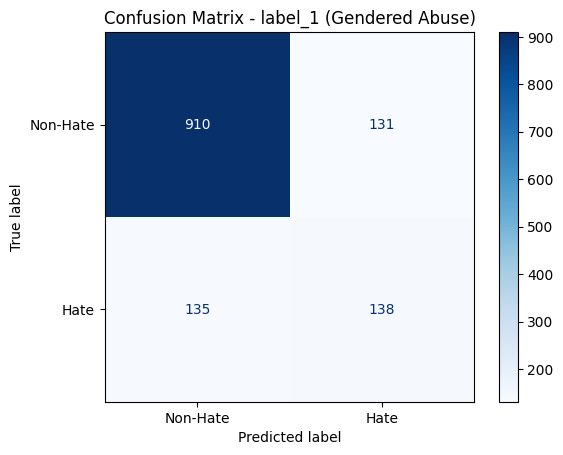


Classification Report for label_3 (Explicit Content):
              precision    recall  f1-score   support

    Non-Hate       0.77      0.70      0.73       839
        Hate       0.54      0.63      0.58       475

    accuracy                           0.68      1314
   macro avg       0.66      0.66      0.66      1314
weighted avg       0.69      0.68      0.68      1314



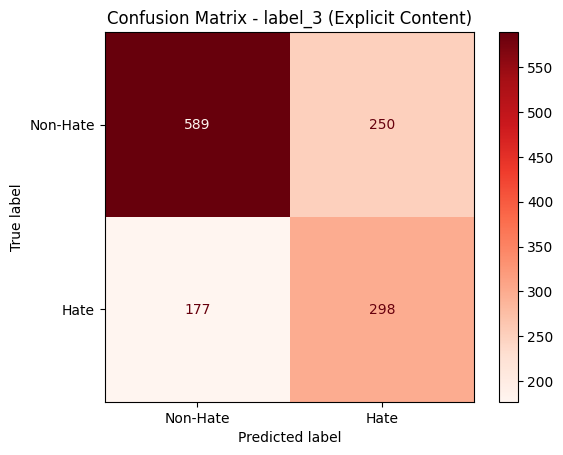

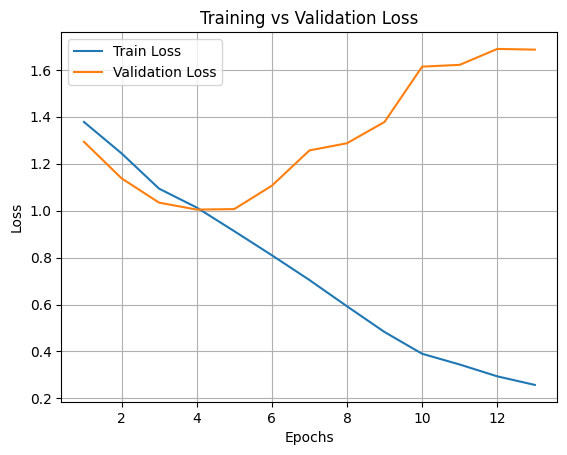

In [16]:
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")

# Train/val split
train_texts, val_texts, train_glove, val_glove, train_y, val_y = train_test_split(
    df['text'].tolist(), X_glove, y, test_size=0.2, random_state=42
)

train_hurtlex = np.array([get_hurtlex_vector(t) for t in train_texts])
val_hurtlex = np.array([get_hurtlex_vector(t) for t in val_texts])

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Datasets and DataLoaders
train_dataset = FusionDataset(train_texts, train_glove, train_y[:, 0], train_y[:, 1], tokenizer, train_hurtlex)
val_dataset = FusionDataset(val_texts, val_glove, val_y[:, 0], val_y[:, 1], tokenizer, val_hurtlex)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model
model = FusionClassifier(embedding_matrix, hurtlex_input_dim=len(cat2idx)).to(device)

optimizer = AdamW([
    {"params": model.bert_encoder.bert.parameters(), "lr": 5e-6},
    {"params": model.fusion.parameters(), "lr": 1e-4},
    {"params": model.classifier_1.parameters(), "lr": 1e-4},
    {"params": model.classifier_3.parameters(), "lr": 1e-4},
    {"params": model.bert_encoder.linear.parameters(), "lr": 1e-4},
])
criterion = nn.BCEWithLogitsLoss()

# Training
train_losses, val_losses = [], []
best_f1 = 0.0

for epoch in range(13):
    print(f"\nEpoch {epoch + 1}/13")
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k not in ["label_1", "label_3"]}
        label_1 = batch["label_1"].unsqueeze(1).to(device)
        label_3 = batch["label_3"].unsqueeze(1).to(device)

        outputs = model(**inputs)
        out_1 = outputs[:, 0].unsqueeze(1)
        out_3 = outputs[:, 1].unsqueeze(1)

        loss_1 = criterion(out_1, label_1)
        loss_3 = criterion(out_3, label_3)
        loss =  loss_1 +  loss_3

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    preds, targets = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", leave=False):
            inputs = {k: v.to(device) for k, v in batch.items() if k not in ["label_1", "label_3"]}
            label_1 = batch["label_1"].unsqueeze(1).to(device)
            label_3 = batch["label_3"].unsqueeze(1).to(device)

            outputs = model(**inputs)
            out_1 = outputs[:, 0].unsqueeze(1)
            out_3 = outputs[:, 1].unsqueeze(1)

            loss_1 = criterion(out_1, label_1)
            loss_3 = criterion(out_3, label_3)
            val_loss += ( loss_1 +  loss_3).item()

            probs = torch.sigmoid(outputs)
            preds += (probs > 0.5).int().cpu().tolist()
            targets += torch.cat([label_1, label_3], dim=1).cpu().int().tolist()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    preds = np.array(preds)
    targets = np.array(targets)

    preds_label_1 = preds[:, 0]
    targets_label_1 = targets[:, 0]
    preds_label_3 = preds[:, 1]
    targets_label_3 = targets[:, 1]

    f1_1 = f1_score(targets_label_1, preds_label_1)
    f1_3 = f1_score(targets_label_3, preds_label_3)
    macro_f1 = f1_score(targets, preds, average="macro")

    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"F1 label_1 (gendered):  {f1_1:.4f}")
    print(f"F1 label_3 (explicit):  {f1_3:.4f}")
    print(f"Macro F1:               {macro_f1:.4f}")

    if macro_f1 > best_f1:
        best_f1 = macro_f1
        torch.save(model.state_dict(), "fusion_model_best_hindi.pt")
        tokenizer.save_pretrained("fusion_tokenizer")
        print(f" Saved best model (Macro F1: {best_f1:.4f})")

# ============================
#  Final Evaluation Report
# ============================

print("\nFinal Evaluation\n")
model.load_state_dict(torch.load("fusion_model_best_hindi.pt"))
model.eval()

final_preds, final_targets = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final Eval", leave=False):
        inputs = {k: v.to(device) for k, v in batch.items() if k not in ["label_1", "label_3"]}
        label_1 = batch["label_1"].unsqueeze(1).to(device)
        label_3 = batch["label_3"].unsqueeze(1).to(device)

        outputs = model(**inputs)
        probs = torch.sigmoid(outputs)
        final_preds += (probs > 0.5).int().cpu().tolist()
        final_targets += torch.cat([label_1, label_3], dim=1).cpu().int().tolist()

# Classification Report & Confusion Matrix
final_preds = np.array(final_preds)
final_targets = np.array(final_targets)

for i, label in enumerate(["label_1 (Gendered Abuse)", "label_3 (Explicit Content)"]):
    y_true = final_targets[:, i]
    y_pred = final_preds[:, i]
    print(f"\nClassification Report for {label}:")
    print(classification_report(y_true, y_pred, target_names=["Non-Hate", "Hate"]))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Hate", "Hate"])
    disp.plot(cmap="Blues" if i == 0 else "Reds")
    plt.title(f"Confusion Matrix - {label}")
    plt.show()

# ============================
#  Loss Plot
# ============================

plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_31/2221819120.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_model_best_hindi.pt"))



Classification Report for label_1 (Gendered Abuse):
              precision    recall  f1-score   support

    Not Hate       0.88      0.86      0.87      1041
        Hate       0.50      0.56      0.53       273

    accuracy                           0.79      1314
   macro avg       0.69      0.71      0.70      1314
weighted avg       0.80      0.79      0.80      1314


Classification Report for label_3 (Explicit Content):
              precision    recall  f1-score   support

    Not Hate       0.77      0.69      0.73       839
        Hate       0.54      0.64      0.58       475

    accuracy                           0.67      1314
   macro avg       0.65      0.66      0.65      1314
weighted avg       0.69      0.67      0.67      1314


Confusion Matrix for label_1:


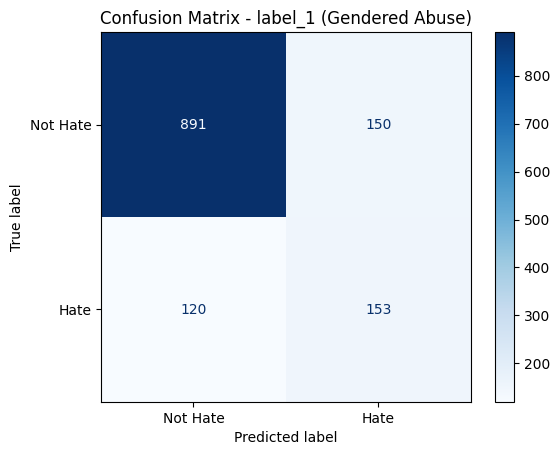


Confusion Matrix for label_3:


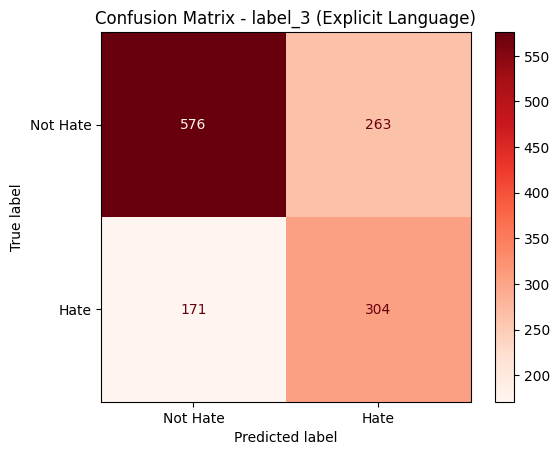

In [11]:
# Load best model
model.load_state_dict(torch.load("fusion_model_best_hindi.pt"))
model.eval()

final_preds, final_targets = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final Eval", leave=False):
        inputs = {k: v.to(device) for k, v in batch.items() if k not in ["label_1", "label_3"]}
        label_1 = batch["label_1"].unsqueeze(1).to(device)
        label_3 = batch["label_3"].unsqueeze(1).to(device)

        outputs = model(**inputs)                         # (B, 2)
        probs = torch.sigmoid(outputs)                    # (B, 2)
        preds = (probs > 0.5).int().cpu().tolist()        # threshold
        final_preds.extend(preds)
        final_targets.extend(torch.cat([label_1, label_3], dim=1).cpu().int().tolist())
 

# Convert to NumPy arrays
final_preds = np.array(final_preds)
final_targets = np.array(final_targets)

# Split per label
preds_label_1 = final_preds[:, 0]
targets_label_1 = final_targets[:, 0]
preds_label_3 = final_preds[:, 1]
targets_label_3 = final_targets[:, 1]

# Print classification reports
print("\nClassification Report for label_1 (Gendered Abuse):")
print(classification_report(targets_label_1, preds_label_1, target_names=["Not Hate", "Hate"]))

print("\nClassification Report for label_3 (Explicit Content):")
print(classification_report(targets_label_3, preds_label_3, target_names=["Not Hate", "Hate"]))

# Confusion matrices
cm1 = confusion_matrix(targets_label_1, preds_label_1)
cm2 = confusion_matrix(targets_label_3, preds_label_3)

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=["Not Hate", "Hate"])
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["Not Hate", "Hate"])

print("\nConfusion Matrix for label_1:")
disp1.plot(cmap="Blues")
plt.title("Confusion Matrix - label_1 (Gendered Abuse)")
plt.show()

print("\nConfusion Matrix for label_3:")
disp2.plot(cmap="Reds")
plt.title("Confusion Matrix - label_3 (Explicit Language)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_31/2770631036.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fusion_model_best_hindi.pt"))


Saved predictions to: Task1_output_Multilabel.csv

Classification Report for label_1 (Gendered Abuse):
              precision    recall  f1-score   support

    Not Hate       0.89      0.88      0.88       879
        Hate       0.55      0.57      0.56       230

    accuracy                           0.82      1109
   macro avg       0.72      0.73      0.72      1109
weighted avg       0.82      0.82      0.82      1109



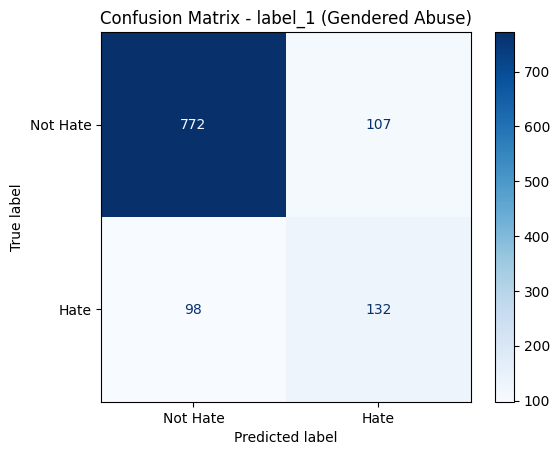


Classification Report for label_3 (Explicit Content):
              precision    recall  f1-score   support

    Not Hate       0.78      0.69      0.74       700
        Hate       0.56      0.67      0.61       409

    accuracy                           0.69      1109
   macro avg       0.67      0.68      0.67      1109
weighted avg       0.70      0.69      0.69      1109



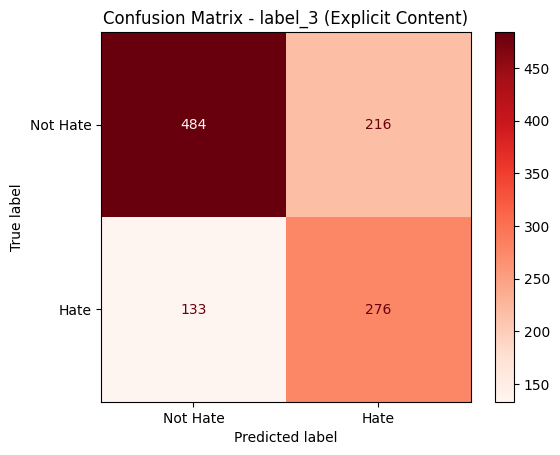


Macro F1-score: 0.5878 | Precision: 0.5566 | Recall: 0.6244


In [17]:
from sklearn.metrics import (
    classification_report, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess test data
test_l1 = pd.read_csv("/kaggle/input/english/test_en_l1.csv", engine="python")
test_l3 = pd.read_csv("/kaggle/input/english/test_en_l3.csv", engine="python")

annotation_cols_1 = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5','en_a6']
annotation_cols_3 = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5','en_a6']

test_l1['label_1'] = test_l1[annotation_cols_1].apply(get_majority_label, axis=1)
test_l3['label_3'] = test_l3[annotation_cols_3].apply(get_majority_label, axis=1)

test_l1['text'] = test_l1['text'].apply(normalize_text)
test_l3['text'] = test_l3['text'].apply(normalize_text)

# Merge both test sets on normalized text
test_df = pd.merge(test_l1[['text', 'label_1']], test_l3[['text', 'label_3']], on='text', how='inner')
test_df.dropna(inplace=True)
test_df[['label_1', 'label_3']] = test_df[['label_1', 'label_3']].astype(int)

# Encode for GloVe + HurtLex
test_seq = keras_tokenizer.texts_to_sequences(test_df['text'])
test_glove = pad_sequences(test_seq, maxlen=max_len, padding='post')
test_label1 = test_df['label_1'].values
test_label3 = test_df['label_3'].values
test_hurtlex = np.array([get_hurtlex_vector(text) for text in test_df['text']])

# Dataset & DataLoader
test_dataset = FusionDataset(test_df['text'].tolist(), test_glove, test_label1, test_label3, tokenizer, hurtlex_inputs=test_hurtlex)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load model
model = FusionClassifier(embedding_matrix, hurtlex_input_dim=len(cat2idx)).to(device)
model.load_state_dict(torch.load("fusion_model_best_hindi.pt"))
model.eval()

# Inference
all_preds, all_targets = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k not in ["label_1", "label_3"]}
        label_1 = batch["label_1"].unsqueeze(1).to(device)
        label_3 = batch["label_3"].unsqueeze(1).to(device)

        outputs = model(**inputs)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int().cpu().tolist()
        all_preds.extend(preds)
        all_targets.extend(torch.cat([label_1, label_3], dim=1).cpu().int().tolist())

# Save predictions
output_df = pd.DataFrame({
    'id': np.arange(1, len(all_preds)+1),
    'label_1': [p[0] for p in all_preds],
    'label_3': [p[1] for p in all_preds]
})
output_df.to_csv('/kaggle/working/Task1_output_Multilabel.csv', index=False)
print("Saved predictions to: Task1_output_Multilabel.csv")

# Evaluation
preds = np.array(all_preds)
targets = np.array(all_targets)

for i, label_name in enumerate(["label_1 (Gendered Abuse)", "label_3 (Explicit Content)"]):
    y_true = targets[:, i]
    y_pred = preds[:, i]
    print(f"\nClassification Report for {label_name}:")
    print(classification_report(y_true, y_pred, target_names=["Not Hate", "Hate"]))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hate", "Hate"])
    disp.plot(cmap="Blues" if i == 0 else "Reds")
    plt.title(f"Confusion Matrix - {label_name}")
    plt.show()

# Overall scores
f1_macro = f1_score(targets, preds, average="macro")
precision_macro = precision_score(targets, preds, average="macro")
recall_macro = recall_score(targets, preds, average="macro")

print(f"\nMacro F1-score: {f1_macro:.4f} | Precision: {precision_macro:.4f} | Recall: {recall_macro:.4f}")
